## Vaaku2Vec

In [1]:
from fastai.text import *
from fastai.lm_rnn import get_rnn_classifer
import html
from nltk import word_tokenize


In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

#Path to the news dataset
PATH=Path('news/')

In [ ]:

class Tokenizer():
    """
    Patching the fastai tokenizer
    """
    def __init__(self, lang='en'):
        pass

    def spacy_tok(self,x):
        return word_tokenize(x)

    def proc_text(self, s):
        return self.spacy_tok(s)

    @staticmethod
    def proc_all(ss, lang):
        tok = Tokenizer(lang)
        return [tok.proc_text(s) for s in ss]

    @staticmethod
    def proc_all_mp(ss, lang='en'):
        ncpus = num_cpus()//2
        with ProcessPoolExecutor(ncpus) as e:
            return sum(e.map(Tokenizer.proc_all, ss, [lang]*len(ss)), [])


## Standardize format
Standardizing dataset for traning the classifier. The news dataset will be tokenized, index to label is created, train-test split is also done for the training dataset.

In [3]:
CLAS_PATH=Path('news/news_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('news/news_lm/')
LM_PATH.mkdir(exist_ok=True)

Our news dataset has 5 classes India, Kerala, Sports, Business, Entertainment from Manorama News



In [2]:
data = pd.read_csv('news/all_news.csv').values
trn_texts,trn_labels = data[::,0],data[::,1]

NameError: name 'pd' is not defined

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [6]:
le.fit(trn_labels)
trn_labels = le.transform(trn_labels)

In [12]:
label2idx = dict()
for i,label in enumerate(le.classes_):
    label2idx[label] = i
np.save("news/news_clas/l2i.npy",label2idx)

In [ ]:
# trn_idx = np.random.permutation(len(trn_texts))
# trn_texts = trn_texts[trn_idx]
# trn_labels = trn_labels[trn_idx]

# trn_texts,trn_labels = trn_texts[:360],trn_labels[:360]

In [13]:
trn_texts,val_texts,trn_labels,val_labels = sklearn.model_selection.train_test_split(trn_texts,trn_labels,test_size=0.1)

In [ ]:
# trn_labels = np.asarray([0 if x>=7 else 1 for x in trn_labels])
# val_labels = np.asarray([0 if x>=7 else 1 for x in val_labels])

In [14]:
col_names = ['labels','text']

We use a random permutation np array to shuffle the text reviews.

In [15]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [16]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [17]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets.

In [18]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

# (CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified news if any.

We first concat all the train and test news into a big chunk. And then we use sklearn splitter to divide up the texts into 90% training and 10% validation sets.

In [19]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [20]:
len(trn_texts), len(val_texts)
trn_labels[90], trn_texts[90]

(4,
 'നെടുമ്പാശേരി വിമാനത്താവളം ശനിയാഴ്ച വരെ അടച്ചിട്ടതോടെ ബുദ്ധിമുട്ടിലായത് പ്രവാസികളുൾപ്പെടെ നിരവധി പേർ. മുല്ലപ്പെരിയാറും ഇടുക്കി–ചെറുതോണി അണക്കെട്ടും തുറന്ന സാഹചര്യത്തിലാണ് വിമാനത്താവളം അടച്ചിട്ടത്.\xa0 ഓപ്പറേഷൻസ് ഏരിയയിലടക്കം വെള്ളം കയറിയിരുന്നു. വിമാനത്താവളത്തിന്റെ ഒരു മതിലും തകര്\u200dന്നു വീണു. വെള്ളം ഒഴുകിപോകാന്\u200d ഒരുവശത്തെ മതിലും പൊളിച്ചു. സാഹചര്യം നിയന്ത്രണാതീതമായതോടെയാണ് വിമാനത്താവളം അടച്ചിടാൻ തീരുമാനിച്ചത്. ഇതോടെ കൊച്ചിയിലേക്ക് ടിക്കറ്റെടുത്തവരും കൊച്ചിയിൽ നിന്ന് യാത്ര തിരിക്കാനിരുന്നവരും ബുദ്ധിമുട്ടിലായി.\xa0 കൊച്ചിയിലേക്ക് പോകേണ്ട വിവിധ വിമാനങ്ങൾ വഴിതിരിച്ചുവിട്ടു. കോഴിക്കോട്, തിരുവനന്തപുരം, ബെംഗളുരു തുടങ്ങിയ സ്ഥലങ്ങളിലേക്കാണ് വിമാനങ്ങളുടെ മാറ്റം. മിക്ക രാജ്യാന്തര വിമാനങ്ങളും ഗൾഫ് മേഖലയിലേക്കുള്ളതാണ്. എയർ ഇന്ത്യ എക്സ്പ്രസ് ഗൾഫിലേക്കുള്ള രണ്ട് വിമാനങ്ങൾ റദ്ദ് ചെയ്യുകയും ചെയ്തു.\xa0 കൊച്ചിയിൽ നിന്നും പുറപ്പെടേണ്ട ഹജ്ജ് തീർഥാടകരുടെ വിമാനങ്ങൾ തിരുവനന്തപുരത്തേക്ക് മാറ്റിയെന്നും ഇവിടെ നിന്നാകും യാത്ര ആരംഭിക്കുകയെന്നും അധികൃതർ അറിയിച്ചു. യാത്രക്കാരുടെ സൗകര്യത്തിനായി കെഎസ്ആർട

In [21]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. As mentioned in the readme, the tokenization is a hard problem, so currently we'll be using nltks  library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [23]:
chunksize=24000

In [24]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
    ' @-@ ','-').replace('\\', ' \\ ').replace('\u200d','').replace('\xa0',' ').replace(
    '\u200c','').replace('“',' ').replace('”',' ').replace('"',' ').replace('\u200d','')
    x = re.sub('[\(\[].*?[\)\]]', '', x)
    x = re.sub('<[^<]+?>', '', x)
    x = re.sub('[A-Za-z]+','ENG ', x)
    x = re.sub(r'\d+.?(\d+)?','NUM ',x).replace("(","").replace(")","")
    return re1.sub(' ', html.unescape(x))

In [25]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [26]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [27]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [28]:
df_trn

In [29]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [30]:
tok_trn[0]

['ENG',
 'ENG',
 'NUM',
 'ചുഴലിക്കാറ്റിന്റെയും',
 'വെളളപ്പൊക്കത്തിന്റെയും',
 'ദുരന്ത',
 'വാർത്തകൾക്കിടയിൽ',
 'നിന്ന്',
 'നൻമയുടെ',
 'ഒരു',
 'നല്ല',
 'കാഴ്ച',
 '.',
 'ചുറ്റും',
 'നിറഞ്ഞ',
 'വെളളത്തിൽ',
 'ഒറ്റപ്പെട്ട',
 'വയോധികനെ',
 'സ്വന്തം',
 'തോളിലേറ്റി',
 'രക്ഷപ്പെടുത്തുന്ന',
 'പൊലീസുദ്യോഗസ്ഥൻ',
 '.',
 'ഇരച്ചുകയറുന്ന',
 'കടൽ',
 'നിമിഷംപ്രതി',
 'കരയെ',
 'വിഴുങ്ങുമ്പോഴാണ്',
 'ആവതില്ലാത്ത',
 'കാലുമായി',
 'പാതിതകർന്ന',
 'വീടിനു',
 'മുന്നിൽ',
 'നിന്ന',
 'വയോധികനെ',
 'കണ്ണമാലി',
 'പൊലീസ്',
 'സ്റ്റേഷനിലെ',
 'പി.എ.ആൻഡ്രൂസ്',
 'കണ്ടത്',
 '.',
 'അവശേഷിക്കുന്ന',
 'സമ്പാദ്യവും',
 'ഉപേക്ഷിച്ചിറങ്ങാൻ',
 'മടിച്ചു',
 'നിന്നയാളെ',
 'പുറത്തേക്കിറക്കാൻ',
 'ഏറെ',
 'നിർബന്ധിക്കേണ്ടി',
 'വന്നു',
 'ആൻഡ്രൂസിന്',
 '.',
 'ഒടുവിൽ',
 'വഴങ്ങിയ',
 'ഈ',
 'മനുഷ്യനോട്',
 'വയ്യാത്ത',
 'കാലുമായി',
 'വെളളത്തിലൂടെ',
 'സ്വയം',
 'നടന്നു',
 'പോകാൻ',
 'കഴിയില്ലെന്ന്',
 'പറഞ്ഞ്',
 'ബോധ്യപ്പെടുത്തി',
 '.',
 'പിന്നെ',
 'സ്വന്തം',
 'തോളിലേറ്റി',
 '.',
 'ദുരന്തങ്ങൾക്കിടയിലും',
 'സേവനസന്നദ്ധരായ',
 'കുറെ',
 'നല്ല',
 'മനുഷ്യരെ',
 '

In [31]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [32]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [33]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [34]:
tok_trn[5]

['ENG',
 'ENG',
 'NUM',
 'പ്രളയക്കെടുതി',
 'നേരിടുന്ന',
 'കേരളത്തിന്',
 'വേണ്ടി',
 'ശബ്ദമുയർത്തി',
 'അറബ്',
 'ആക്ടിവിസ്റ്റ്',
 'ഖാലിദ്',
 'അൽ',
 'അമേരി',
 '.',
 'കേരളം',
 'ഇതുവരെ',
 'കാണാത്ത',
 'പ്രളയത്തെ',
 'നേരിടുകയാണെന്നും',
 'ദുരിതാശ്വാസ',
 'നിധിയിലേക്ക്',
 'സഹായം',
 'നൽകണമെന്നും',
 'അമേരി',
 'പറയുന്നു',
 '.',
 'ആക്ട്',
 'ഫോർ',
 'കേരള',
 'എന്ന',
 'പ്ലക്കാർഡുയർത്തി',
 'തന്റെ',
 'ഫെയ്സ്ബുക്ക്',
 'പേജിലൂടെയാണ്',
 'അമേരി',
 'വിഡിയോ',
 'പങ്കുവെച്ചത്',
 '.',
 'അമേരയുടെ',
 'വാക്കുകൾ',
 ';',
 '``',
 'നൂറ്റാണ്ടിലെ',
 'ഏറ്റവും',
 'വലിയ',
 'പ്രളയത്തെ',
 'നേരിടുകയാണ്',
 'ഇന്ത്യയിലെ',
 'കേരളം',
 'എന്ന',
 'സംസ്ഥാനം',
 '.',
 'നൂറിലധികം',
 'പേർ',
 'മരിച്ചു',
 '.',
 'നിരവധി',
 'പേർക്ക്',
 'വീടുകൾ',
 'നഷ്ടമായി',
 '.',
 'ഡാമുകൾ',
 'നിറഞ്ഞൊഴുകുന്നു',
 '.',
 'ഉരുൾപൊട്ടുന്നു',
 '.',
 'വിമാനത്താവളങ്ങൾ',
 'അടച്ചിട്ടു',
 '.',
 'ജനങ്ങൾ',
 'ദുരിതത്തിലാണ്',
 '.',
 'ഇതെന്ന്',
 'തീരുമെന്ന്',
 'അവിടുത്തെ',
 'ജനങ്ങൾക്ക്',
 'അറിയില്ല',
 ',',
 'അടുത്തത്',
 'എന്തെന്നും',
 'അറിയില്ല',
 '.',
 'മുഖ്യമന്ത്രിയുടെ',
 'ദുര

In [35]:
' '.join(tok_trn[5])

"ENG ENG NUM പ്രളയക്കെടുതി നേരിടുന്ന കേരളത്തിന് വേണ്ടി ശബ്ദമുയർത്തി അറബ് ആക്ടിവിസ്റ്റ് ഖാലിദ് അൽ അമേരി . കേരളം ഇതുവരെ കാണാത്ത പ്രളയത്തെ നേരിടുകയാണെന്നും ദുരിതാശ്വാസ നിധിയിലേക്ക് സഹായം നൽകണമെന്നും അമേരി പറയുന്നു . ആക്ട് ഫോർ കേരള എന്ന പ്ലക്കാർഡുയർത്തി തന്റെ ഫെയ്സ്ബുക്ക് പേജിലൂടെയാണ് അമേരി വിഡിയോ പങ്കുവെച്ചത് . അമേരയുടെ വാക്കുകൾ ; `` നൂറ്റാണ്ടിലെ ഏറ്റവും വലിയ പ്രളയത്തെ നേരിടുകയാണ് ഇന്ത്യയിലെ കേരളം എന്ന സംസ്ഥാനം . നൂറിലധികം പേർ മരിച്ചു . നിരവധി പേർക്ക് വീടുകൾ നഷ്ടമായി . ഡാമുകൾ നിറഞ്ഞൊഴുകുന്നു . ഉരുൾപൊട്ടുന്നു . വിമാനത്താവളങ്ങൾ അടച്ചിട്ടു . ജനങ്ങൾ ദുരിതത്തിലാണ് . ഇതെന്ന് തീരുമെന്ന് അവിടുത്തെ ജനങ്ങൾക്ക് അറിയില്ല , അടുത്തത് എന്തെന്നും അറിയില്ല . മുഖ്യമന്ത്രിയുടെ ദുരിതാശ്വാസനിധിയിലേക്ക് സംഭാവന ചെയ്ത് സഹായിക്കാം . യുഎഇയിലുള്ളവർക്ക് ലുലു എക്സ്ചേഞ്ച് വഴിയും മറ്റും പണമയക്കാം . എല്ലാവരും ഒരുമിച്ച് നിൽക്കേണ്ട സമയമാണിത് . ദുരിതാശ്വാസനിധിയെക്കുറിച്ചുള്ള വിവരങ്ങൾ പരമാവധി ആളുകളിലേക്കെത്തിക്കുക , കേരളത്തിൽ നിന്നുള്ള വാര്ത്തകള് ഷെയർ ചെയ്യുക . കേരളത്തിലുള്ളവരേ , നിങ്ങളെ ഞങ്ങള് കേൾക്കുന്നുണ്ട് , പ്രാർഥിക്കു

In [36]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 124629),
 ('ENG', 39424),
 ('NUM', 25848),
 (',', 20192),
 ('ഒരു', 6616),
 ('ഈ', 5353),
 ('എന്ന', 3783),
 ('പറഞ്ഞു', 3644),
 ('നിന്ന്', 3347),
 ('തന്നെ', 3162),
 ('ആ', 2492),
 ('പൊലീസ്', 2381),
 ('പുതിയ', 1902),
 ('’', 1841),
 ('‘', 1721),
 ('കഴിഞ്ഞ', 1681),
 ('എന്നാൽ', 1666),
 ('?', 1586),
 ('പറയുന്നു', 1582),
 ('ചെയ്തു', 1562),
 ('ശേഷം', 1486),
 ('എന്ന്', 1449),
 ('അദ്ദേഹം', 1411),
 ('ചിത്രം', 1409),
 ('വലിയ', 1407)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [37]:
max_vocab = 60000
min_freq = 1

In [38]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [39]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [40]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [41]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [55]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [56]:
vs=len(itos)
vs,len(trn_lm)

(60002, 8426)

## wikitext conversion

We could start from scratch and try to learn the structure of the Malayalam language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

We are using malayalam article dataset, see README

The language model for wikitexthas been pre-trained and the weights can be downloaded here: [Link](https://www.dropbox.com/sh/a9wmsg5cjpzmyg1/AABmyHP-4bLmqrwJSB5-KeU1a?dl=0). 

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target news LM so that the weights can be loaded up.

In [58]:
em_sz,nh,nl = 400,1150,3

In [59]:
#path to the news dataset
PATH2 = Path('news/')

In [60]:
#path to the pretrained LM
PRE_PATH = Path("wiki/ml/")
PRE_LM_PATH = PRE_PATH/'models/fwd_.h5'

In [61]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target news LM.

In [62]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [63]:
itos2 = pickle.load((PRE_PATH/'tmp/itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the news LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown news tokens that do not exist in wikitext.

In [64]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [65]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new news language pytorch model!

## Language model
Fine Tune our LM using the news dataset.

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the Malayalam news LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [66]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90% training set and 10% validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [67]:
# from keras.preprocessing.sequence import pad_sequences
# trn_lm  = pad_sequences(trn_lm,maxlen=250,padding='post')
# val_lm = pad_sequences(val_lm,maxlen=250,padding='post')

In [68]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH2, 1, vs, trn_dl,val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [69]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [70]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [71]:
learner.model.load_state_dict(wgts)

In [72]:
trn_lm.shape

(8426,)

We set learning rates and fit our news LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext learn better weights.

In [73]:
lr=1e-3
lrs = lr

In [75]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      6.971147   6.238319   0.289476  



[array([6.23832]), 0.2894755892048672]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [76]:
learner.save('lm_last_ft')

In [77]:
learner.load('lm_last_ft')

In [78]:
learner.unfreeze()

In [79]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      6.468911   5.840285   0.306474  



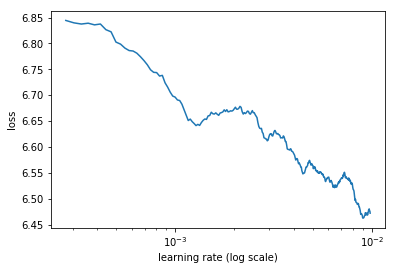

In [80]:
learner.sched.plot()

In [81]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                   
    0      6.533936   5.901477   0.313534  
    1      6.139462   5.6191     0.31827                    
    2      5.737526   5.462279   0.320515                   
    3      5.442615   5.386766   0.317344                   
    4      5.231953   5.297448   0.32366                    
    5      4.980866   5.317917   0.317079                   
    6      4.80736    5.284127   0.319                      
    7      4.662245   5.271721   0.316765                   
    8      4.499108   5.27554    0.319053                   
    9      4.501692   5.193139   0.324765                   
    10     4.347641   5.23655    0.320109                   
    11     4.188502   5.282732   0.316333                   
    12     4.166089   5.267878   0.317631                   
    13     4.053047   5.282663   0.316249                   
    14     4.128179   5.269152   0.317855                   



[array([5.26915]), 0.3178545034970631]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [82]:
learner.save('lm1')

In [83]:
learner.save_encoder('lm1_enc')

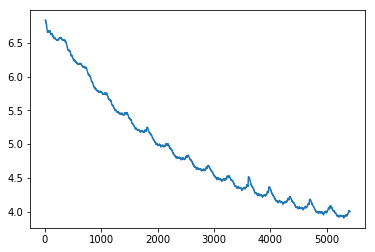

In [84]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [85]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None)

In [86]:
# from sklearn.preprocessing import LabelEncoder
# lb = LabelEncoder()

In [87]:
# df_trn[0] = lb.fit_transform(df_trn.values[::,0])
# df_val[0] = lb.transform(df_val.values[::,0])

In [88]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

In [89]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None,chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None,chunksize=chunksize)

In [90]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [91]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [92]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [93]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [94]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [95]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained news. The steps to create the classifier model are similar to the ones for the LM.

In [96]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [97]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [98]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [99]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [100]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [101]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [102]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [103]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [104]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [105]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [106]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [107]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [108]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [109]:
learn.freeze_to(-1)

 78%|███████▊  | 276/352 [00:22<00:06, 12.13it/s, loss=2.75] 

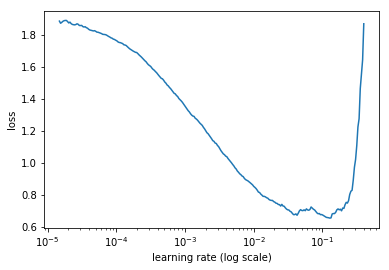

In [110]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [112]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.398827   0.274607   0.911355  


[array([0.27461]), 0.9113550519437481]

In [113]:
learn.save('clas_0')

In [114]:
learn.load('clas_0')

In [115]:
learn.freeze_to(-2)

In [116]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.359585   0.267299   0.898516  


[array([0.2673]), 0.8985162197100847]

In [117]:
learn.save('clas_1')

In [118]:
learn.load('clas_1')

In [119]:
learn.unfreeze()

In [120]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.335852   0.260034   0.90821   
    1      0.330256   0.251528   0.905752                    
    2      0.318251   0.265104   0.912205                    
    3      0.212166   0.259973   0.902437                    
    4      0.243213   0.272938   0.921619                    
    5      0.138659   0.289464   0.908703                    
    6      0.128009   0.322819   0.914114                    
    7      0.120581   0.356914   0.922777                     
    8      0.103825   0.387603   0.915233                     
    9      0.075819   0.31809    0.914823                     
    10     0.046834   0.379487   0.913247                     
    11     0.0489     0.395307   0.920358                     
    12     0.039453   0.397929   0.918573                     
    13     0.033615   0.393666   0.920896                     


[array([0.39367]), 0.9208963442373963]

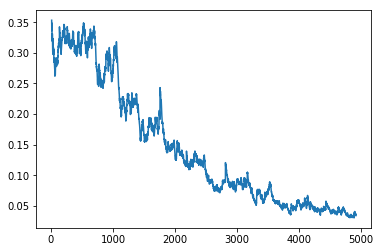

In [121]:
learn.sched.plot_loss()

In [122]:
#save the weight for prediction.
learn.save('clas_2')